In [2]:
import torch
import matplotlib.pyplot as plt
from math import pi

from utils.metrics import get_w2
from utils.datasets import GMM

tensor([50.3338+0.j,  2.6746+0.j], device='cuda:0')
tensor([[1.0000e+00, 4.3436e-08],
        [4.3436e-08, 1.0000e+00]], device='cuda:0')


/tmp/ipykernel_95758/4283352477.py:13: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1688.)
  a_isotropic = (torch.linalg.inv(data_cov).cholesky().T @ a_centered.T).T


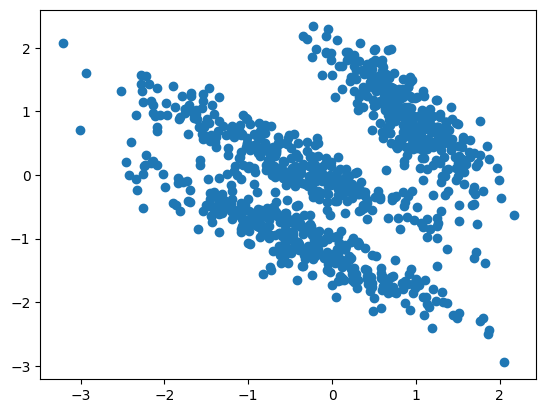

tensor(0.4036, device='cuda:0')
tensor(6.8662, device='cuda:0')


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = 1000
covs = torch.tensor([[[3., -1.],[-1., 2.]], [[3., 1.8],[1.8, 2.]], [[3., -1.],[-1., 2.]]], device=device)
means = torch.tensor([[0,3.], [10,5.], [-6.,0]],device=device)
weights = torch.ones(means.shape[0],device=device)/means.shape[0]
gmm = GMM(weights,means,covs)
# l_cov = torch.linalg.cholesky(cov)
a = gmm.sample(1000)
a_centered = a - a.mean(0)

data_cov = a_centered.T.cov()

a_isotropic = (torch.linalg.inv(data_cov).cholesky().T @ a_centered.T).T
print(torch.linalg.eigvals(data_cov))
noise = torch.randn((n,2),device=device)
noise_shift =(data_cov @ torch.randn((n,2),device=device).T).T / (2 * pi)

print(a_isotropic.T.cov())
# plt.scatter(a_centered[:,0].cpu(),a_centered[:,1].cpu())
# plt.scatter(noise[:,0].cpu(),noise[:,1].cpu())
# plt.scatter(noise_shift[:,0].cpu(),noise_shift[:,1].cpu())
plt.scatter(a_isotropic[:,0].cpu(),a_isotropic[:,1].cpu())

plt.show()



print(get_w2(noise,a_isotropic))
print(get_w2(noise_shift,a_isotropic))


In [6]:
a = torch.randn((2,2),device=device)
b = torch.randn((2,2),device=device)
print(a.matrix_exp())
print(b.matrix_exp())
c = torch.cat((a.unsqueeze(0),b.unsqueeze(0)))
print(c.matrix_exp())

tensor([[ 0.6609, -0.5667],
        [ 1.3103,  0.0913]], device='cuda:0')
tensor([[ 0.3454,  0.3569],
        [-0.0702,  0.0582]], device='cuda:0')
tensor([[[ 0.6609, -0.5667],
         [ 1.3103,  0.0913]],

        [[ 0.3454,  0.3569],
         [-0.0702,  0.0582]]], device='cuda:0')


In [9]:
d = torch.randn((3,2,2))
print(d.T.shape)
print(d.mT.shape)

torch.Size([2, 2, 3])
torch.Size([3, 2, 2])
